## Xgboost model for submission

### Import statements of preprocessed data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()


%matplotlib inline
# Reading datasets from external csv file
print('loading train data ')
train_x = pd.read_csv('train_x.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'user_total_orders':np.int8,
            'user_total_items':np.int8,
            'total_distinct_items':np.int8,
            'user_average_days_between_orders':np.float32,
            'user_average_basket':np.float32,
            'dow':np.int8,
            'order_hour_of_day':np.int8,
            'days_since_prior_order':np.int16,
            'days_since_ratio':np.float32,
            'asile_id':np.int8,
            'department_id':np.int8,
            'product_orders':np.int16,
            'product_reorders':np.int64,
            'product_reorders_rate':np.float32,
            'z':np.int32,
            'UP_orders':np.int8,
            'UP_orders_ratio':np.float32,
            'UP_last_order_id':np.int32,
            'UP_average_pos_in_cart':np.float32,
            'UP_reorder_rate':np.float32,
            'UP_orders_since_last':np.int8,
            'UP_delta_hour_vs_last':np.int8})

train_y = pd.read_csv('train_y.csv')
train_y = train_y.as_matrix()



print('loading test data')

test_x = pd.read_csv('test_x.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'user_total_orders':np.int8,
            'user_total_items':np.int8,
            'total_distinct_items':np.int8,
            'user_average_days_between_orders':np.float32,
            'user_average_basket':np.float32,
            'dow':np.int8,
            'order_hour_of_day':np.int8,
            'days_since_prior_order':np.int16,
            'days_since_ratio':np.float32,
            'asile_id':np.int8,
            'department_id':np.int8,
            'product_orders':np.int16,
            'product_reorders':np.int64,
            'product_reorders_rate':np.float32,
            'z':np.int32,
            'UP_orders':np.int8,
            'UP_orders_ratio':np.float32,
            'UP_last_order_id':np.int32,
            'UP_average_pos_in_cart':np.float32,
            'UP_reorder_rate':np.float32,
            'UP_orders_since_last':np.int8,
            'UP_delta_hour_vs_last':np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

value = 0
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(value)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)

test_orders = orders[orders.eval_set == 'test']

print('finished')

/home/amaresh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading train data 
loading test data
loading orders
finished


### Training the model

In [2]:
# Features used for training the model
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate','dow','UP_orders_since_last','UP_delta_hour_vs_last'] 

xgdmat = xgb.DMatrix(train_x[f_to_use], train_y)
del train_x
del train_y

our_params = {'alpha': 2e-05,
 'colsample': 0.7,
 'colsample_bytree': 0.99,
 'eta': 0.3,
 'eval_metric': 'mae',
 'lambda': 10,
 'max_depth': 4,
 'min_child_weight': 8,
 'objective': 'binary:logistic',
 'subsample': 0.7}

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 100)
del xgdmat

# Gathering required features for test_orders and prediction
testdmat = xgb.DMatrix(test_x[f_to_use])
y_pred = final_gb.predict(testdmat)
del testdmat

test_x['preds']=y_pred

### Feature importance

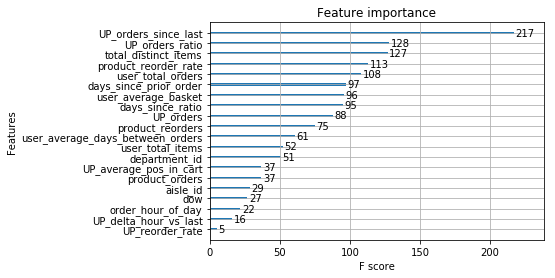

In [5]:
#Plotting feature importance
xgb.plot_importance(final_gb)

### Formatting for submission

In [7]:
# Threshold value for classification is the error rate encountered in cross validation
thres = 0.20
d = dict()
for row in test_x.itertuples():
    if row.preds > thres:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('submission_xgboost.csv', index=False)